# Analiza sieci tramwajowej w Poznaniu

Przedmiotem analizy jest sieć tramwajowa w Poznaniu. Dane o przejazdach pozyskaliśmy samodzielnie ze strony ZTM: https://www.ztm.poznan.pl/pl/rozklad-jazdy/ przy użyciu skryptu skrapującego. Dane o lokalizacji przystanków pozyskaliśmy ręcznie z Google Maps, ponieważ nigdzie niestety takie dane nie były dostępne.

### Pytania o charakterze biznesowym:
* Które części miasta mogą cierpieć z powodu nierozbudowanej sieci tramwajowej?
* Które węzły są w sieci najważniejsze z punktu widzenia ewentualnego wyłączenia z użycia?

## 0. Importy

In [1]:
from copy import deepcopy
from heapq import nlargest
from itertools import combinations
from operator import itemgetter
from random import seed, shuffle
from typing import Mapping, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
from tqdm import tqdm
from math import sin, cos, sqrt, atan2, radians

seed(0)
plt.style.use('ggplot')

## 1. Wczytanie danych

In [2]:
def read_routes() -> Mapping[str, List]:
    routes = {}
    
    trams = list(range(1, 19)) + [201]
    for tram in trams:
        stops = None
        with open(f'./data/{tram}there') as f:
            stops = f.read().splitlines()
            stops = [s.strip() for s in stops]
        routes[f"{tram}there"] = stops

        with open(f'./data/{tram}back') as f:
            stops = f.read().splitlines()
            stops = [s.strip() for s in stops]
        routes[f"{tram}back"] = stops
    return routes

def read_coords() -> Mapping[str, Tuple]:
    result = {}
    with open(f'./data/coords') as f:
        lines = f.read().splitlines()
        for line in lines:
            line = line.strip()
            stop_name, x, y  = line.split(",")
            result[stop_name] = (float(x.strip()), float(y.strip()))
    return result

In [3]:
route_to_stops : Mapping[str, List] = read_routes()

In [4]:
stop_to_location : Mapping[str, Tuple] = read_coords()

In [5]:
# just to check if we have all coords
for r, stops in route_to_stops.items():
    for stop in stops:
        if stop not in stop_to_location:
            print(stop)

### Przykładowa trasa: 16there

In [6]:
route_to_stops['16there']

['Franowo (FRWO42)',
 'Szwajcarska (SZWA42)',
 'Szwedzka (SZWE42)',
 'Piaśnicka/Kurlandzka (PK42)',
 'Piaśnicka Rynek (PIAR42)',
 'Os. Lecha (OSLE42)',
 'Os. Tysiąclecia (OSTY42)',
 'Polanka (POKA42)',
 'Kórnicka (KORN44)',
 'Kórnicka (KORN45)',
 'Baraniaka (BAKA42)',
 'Rondo Śródka (ROSR44)',
 'Rondo Śródka (ROSR42)',
 'Katedra (KATE42)',
 'Małe Garbary (MAGA42)',
 'Pl. Wielkopolski (PLWI42)',
 'Pl. Ratajskiego (PLRA42)',
 'Fredry (FRRY42)',
 'Most Teatralny (MT44)',
 'Słowiańska (SLKA41)',
 'Aleje Solidarności (ALSO41)',
 'Lechicka Poznań Plaza (LECH41)',
 'Kurpińskiego (KURP41)',
 'Szymanowskiego (SZYM41)',
 'Os. Sobieskiego (SOB41)']

### Przykładowa lokalizacja

In [7]:
stop_to_location['Franowo (FRWO42)']

(52.38168410642868, 17.00151548366702)

## 2. Utworzenie skierowanego Multigrafu

In [8]:
G = nx.MultiDiGraph()

# Adding nodes (stops)
for stop_name, coords in stop_to_location.items():
    G.add_node(stop_name, location=(coords[1], coords[0]))

# Adding directed edges (between each pair of stops on a route)
for tram in list(range(1, 19)) + [201]:
    edge_color = np.random.rand(3,)  # assign some random color to a tram route (there and back)

    route = f"{tram}there"
    stops_there = route_to_stops[route]
    edges = [(stops_there[i],stops_there[i+1]) for i in range(len(stops_there)-1)]
    G.add_edges_from(edges, route=route, color=edge_color)

    route = f"{tram}back"
    stops_back = route_to_stops[route]
    edges = [(stops_back[i],stops_back[i+1]) for i in range(len(stops_back)-1)]
    G.add_edges_from(edges, route=route, color=edge_color)

#     G.add_edge(stops_there[-1], stops_back[0]) # closing the cycle
#     G.add_edge(stops_back[-1], stops_there[0]) # closing the cycle

In [9]:
# list(G)


### Narysowany graf (bez etykiet)

Etykiety niestety przyciemniały ogólny obraz grafu. Wydaje się, że jest on wiernym odwzorowaniem sieci tramwajowej w Poznaniu. Trasy zostały pokolorowane w zależności od numeru tramwaju.

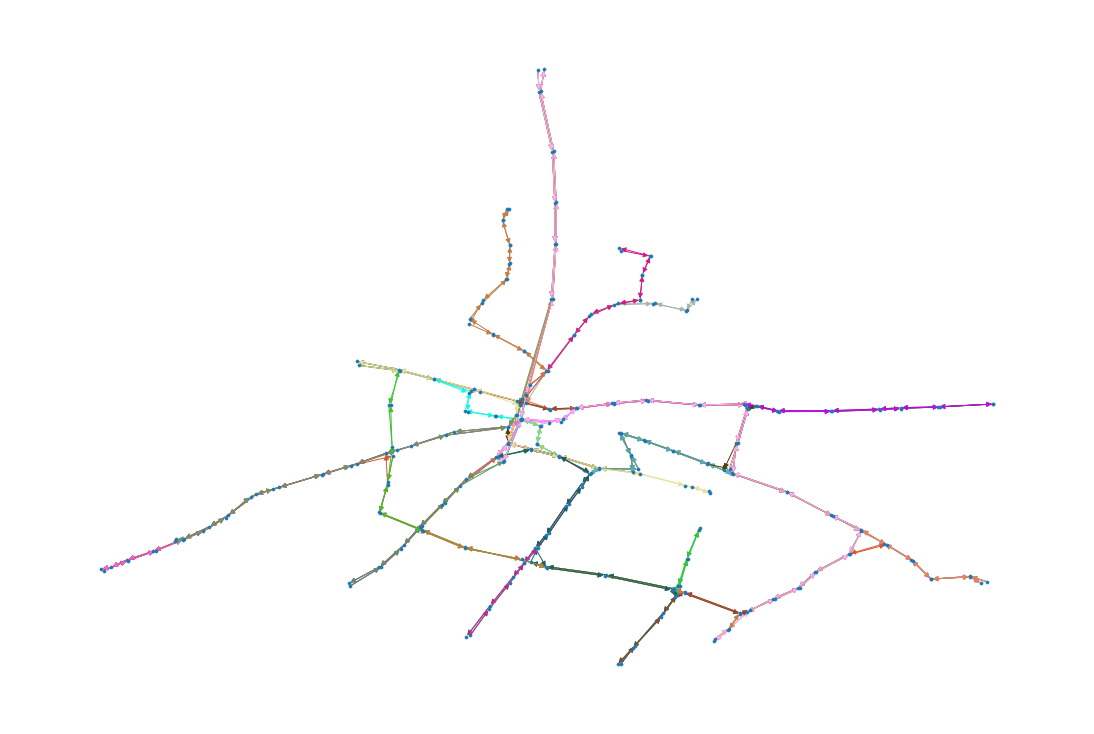

In [10]:
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(G,'color').values()
nx.draw(G, nx.get_node_attributes(G, 'location'), with_labels=False, node_size=10, edge_color=colors)

## 3. Rozkład stopni wyjściowych i wejściowych

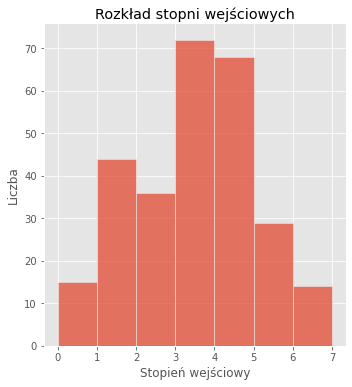

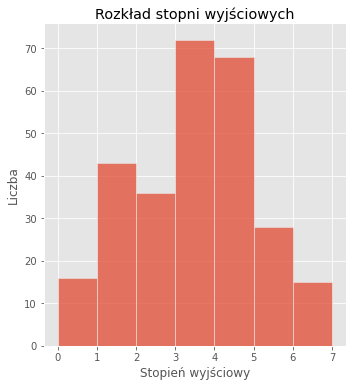

In [11]:
# Rozkład stopni wejściowych
degree_sequence = [d for n, d in G.in_degree()]

sns.displot(degree_sequence, binwidth=1)
plt.title("Rozkład stopni wejściowych")
plt.ylabel("Liczba")
plt.xlabel("Stopień wejściowy")
plt.show()

# Rozkład stopni wyjściowych
degree_sequence = [d for n, d in G.out_degree()]
sns.displot(degree_sequence, binwidth=1)
plt.title("Rozkład stopni wyjściowych")
plt.ylabel("Liczba")
plt.xlabel("Stopień wyjściowy")
plt.show()

Komentarz: Wykresy wyglądają tak samo, ponieważ w większości przypadków do każdego z wierzchołków w naszym grafie wchodzi tyle samo krawędzi ile wychodzi. (Zazwyczaj tramwaje kursują w obie strony po tych samych trasach)

Sprawdźmy, który z wierzchołków ma największy stopień wejściowy/wyjściowy:

In [12]:
max([(d,n) for n, d in G.in_degree()])

(7, 'Most Dworcowy (MODW72)')

In [13]:
max([(d,n) for n, d in G.out_degree()])

(7, 'Most Dworcowy (MODW72)')

## Odpowiedź na pytanie numer 2: 
Największy stopień wejściowy i wyjściowy ma **Most Dworcowy**. Z tego powodu węzeł ten może być ważny i w przypadku remontu wiele tras będzie musiało ulec zmianie.

### Rozkład długości najkrótszych ścieżek

In [14]:
shortest_paths_lengths = []

for source, target in tqdm(combinations(stop_to_location.keys(), 2)):
    try:
        path = nx.shortest_path(G, source=source, target=target)
        shortest_paths_lengths.append(len(path))
    except nx.NetworkXNoPath:
        # Errors like that are because we don't close the cycle explicitly. 
#         print(f"No path between {source} and {target}")
        pass

38503it [00:01, 24254.68it/s]


Text(0.5, 6.79999999999999, 'Długość najkrótszej ścieżki')

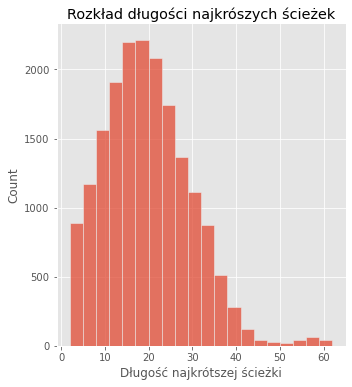

In [15]:
sns.displot(shortest_paths_lengths, binwidth=3)
plt.title("Rozkład długości najkrószych ścieżek")
plt.xlabel("Liczba ścieżek")
plt.xlabel("Długość najkrótszej ścieżki")

Rozkład jest prawostronnie skośny, tzn istnieją pewne pary wierzchołków, dla których najkrótsza ścieżka prowadzi przez aż 60 wierzchołków w grafie!

### Jakie to pary?

In [16]:
shortest_paths = []

for source, target in tqdm(combinations(stop_to_location.keys(), 2)):
    try:
        path = nx.shortest_path(G, source=source, target=target)
        shortest_paths.append((len(path), source, target))
    except nx.NetworkXNoPath:
        # Errors like that are because we don't close the cycle explicitly. 
#         print(f"No path between {source} and {target}")
        pass

38503it [00:01, 35196.11it/s]


In [17]:
sorted(shortest_paths, reverse=True)[:10]

[(62, 'Dworzec Zachodni (DWZA71)', 'Dworzec Zachodni (DWZA72)'),
 (62, 'Dworzec Zachodni (DWZA71)', 'Bukowska (BUKO41)'),
 (62, 'Bukowska (BUKO42)', 'Bukowska (BUKO41)'),
 (61, 'Rondo Nowaka-Jeziorańskiego (RONJ74)', 'Bukowska (BUKO41)'),
 (61, 'Park Wilsona (PAWI71)', 'Dworzec Zachodni (DWZA72)'),
 (61, 'Park Wilsona (PAWI71)', 'Bukowska (BUKO41)'),
 (61, 'Dworzec Zachodni (DWZA71)', 'Rondo Nowaka-Jeziorańskiego (RONJ73)'),
 (61, 'Dworzec Zachodni (DWZA71)', 'Półwiejska (POLW92)'),
 (61, 'Dworzec Zachodni (DWZA71)', 'Park Wilsona (PAWI72)'),
 (61, 'Bukowska (BUKO42)', 'Rondo Nowaka-Jeziorańskiego (RONJ73)')]

Są to wierzchołki po przeciwległych stronach drogi... Ma to trochę sensu, ponieważ aby do nich dotrzeć (tramwajem!) zazwyczaj trzeba gdzieś zrobić jakąś pętlę, a więc pokonać bardzo wiele wierzchołków. Jednak nie do końca takiej odpowiedzi się spodziewaliśmy. Aby dotrzeć do interesującej nas odpowiedzi, musielibyśmy połączyc wierzchołki po przeciwległej stronie ulicy.


### Rozkład pośrednictwa
Ponieważ pośrednictwo nie jest możliwe do policzenia w skierowanym multigrafie, zmuszeni jesteśmy przejść na zwykły graf nieskierowany...

In [18]:
code2name = lambda x: x.split(' (')[0]

D = nx.Graph()

# Adding nodes (stops)
for stop_code, coords in stop_to_location.items():
    stop_name = code2name(stop_code)
    if stop_name not in D:
        D.add_node(stop_name, location=(coords[1], coords[0]))

colors = sns.color_palette('Set3', n_colors=20)
# Adding directed edges (between each pair of stops on a route)
for i, tram in enumerate(list(range(1, 19)) + [201]):
    edge_color = colors[i]  # assign some random color to a tram route (there and back)

    route = f"{tram}there"
    stops_there = route_to_stops[route]
    edges = [(code2name(stops_there[i]),code2name(stops_there[i+1])) for i in range(len(stops_there)-1)]
    D.add_edges_from(edges, route=route, color=edge_color)

    route = f"{tram}back"
    stops_back = route_to_stops[route]
    edges = [(code2name(stops_back[i]),code2name(stops_back[i+1])) for i in range(len(stops_back)-1)]
    D.add_edges_from(edges, route=route, color=edge_color)

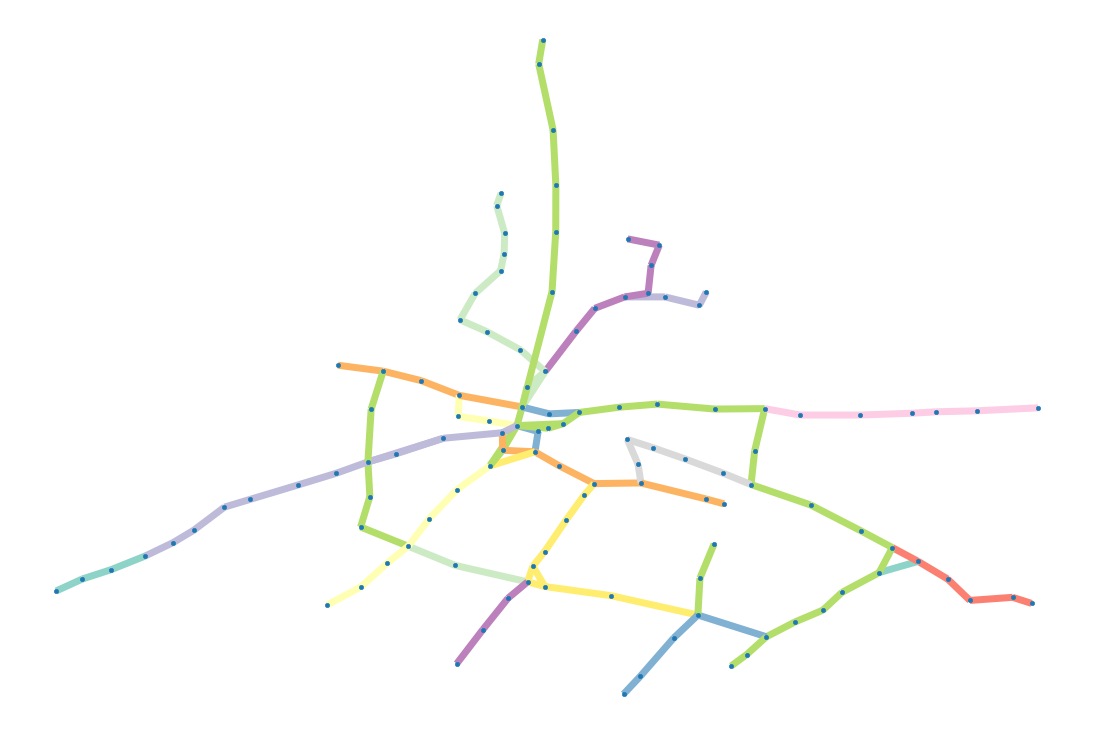

In [19]:

plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(D,'color').values()
nx.draw(D, nx.get_node_attributes(D, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)



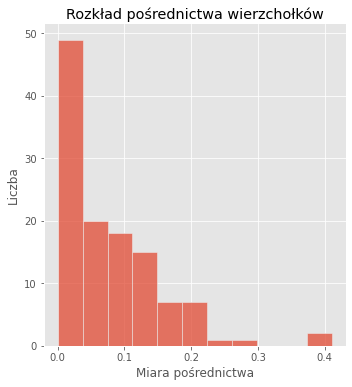

In [20]:
degree_sequence = sorted(nx.betweenness_centrality(D).items(), key=itemgetter(1), reverse=True)

sns.displot(list(map(itemgetter(1), degree_sequence)))
plt.title("Rozkład pośrednictwa wierzchołków")
plt.ylabel("Liczba")
plt.xlabel("Miara pośrednictwa")
plt.show()

Z rozkładu wynika, że mamy kilka kluczowych przystanków, przez które przechodzi większość najkrótszych ścieżek:

In [21]:
for stop_name, centrality in degree_sequence[:10]:
    print(f'{stop_name:<25} {centrality:.2f}')

Most Teatralny            0.41
Rondo Kaponiera           0.39
Wielkopolska              0.28
Głogowska/Hetmańska       0.26
Traugutta                 0.22
Kolejowa                  0.21
Dworzec Zachodni          0.20
Rondo Śródka              0.20
Rondo Nowaka-Jeziorańskiego 0.20
Pl. Ratajskiego           0.20


Obserwujemy, że zgodnie z naszymi przewidywaniami najwyższą miarą pośrednictwa odznaczają się przystanki w centrum.

### Rozkład lokalnych współczynników grupowania
Po policzeniu współczynników grupowania dla grafu skierowanego, gdzie każdy przystanek 'przekazywał' tramwaj do kolejnego, współczynnik grupowania był zawsze równy 0. W związku z tym przekształcamy nasz graf do postaci nieskierowanej gdzie nazwa 'Kaponiera' oznacza jedno miejsce, a nie kilka przystanków.

In [22]:
clustering_coeff = sorted(nx.clustering(D).items(), key=itemgetter(1), reverse=True)
for stop_name, coeff in clustering_coeff[:10]:
    print(f'{stop_name:<25} {coeff:.2f}')

Poznańska                 1.00
Wojskowa                  1.00
Zamek                     1.00
Most Dworcowy             0.50
Piaśnicka Rynek           0.33
Os. Czecha                0.33
Rolna                     0.33
Pamiątkowa                0.33
Os. Lecha                 0.33
Dworzec Zachodni          0.33


### Miary oceny sieci: gęstość, współczynnik centralizacji, promień

In [23]:
edges = len(D.edges())
vertices = len(D.nodes())
f'Gęstość: {edges/(vertices*(vertices-1)):.3f}'

'Gęstość: 0.010'

Gęstość mała bo praktycznie każdy ma tylko jednego sąsiada


In [24]:
centrality = sorted(nx.eigenvector_centrality(D).items(), key=itemgetter(1), reverse=True)

for stop_name, coeff in centrality[:10]:
    print(f'{stop_name:<25} {coeff:.2f}')

Rondo Kaponiera           0.51
Dworzec Zachodni          0.44
Most Dworcowy             0.38
Poznań Główny             0.28
Bałtyk                    0.25
Most Teatralny            0.23
Towarowa                  0.20
Gwarna                    0.20
Zamek                     0.18
Stare Zoo                 0.15


Komentarz do centralności


In [25]:
shortest_paths = []

for source, target in tqdm(combinations(D.nodes(), 2)):
    try:
        path = nx.shortest_path(D, source=source, target=target)
        shortest_paths.append((len(path), source, target))
    except nx.NetworkXNoPath:
        # Errors like that are because we don't close the cycle explicitly.
#         print(f"No path between {source} and {target}")
        pass

diameter = max(shortest_paths, key=itemgetter(0))
diameter

7140it [00:00, 35773.73it/s]


(29, 'Junikowo', 'Franowo')

Komentarz do przekątnej



### Podział sieci na moduły


In [26]:
groups = greedy_modularity_communities(D)

colors = sns.color_palette('hls', n_colors=len(groups))
shuffle(colors)

node2color = {node_name:colors[group_id] for group_id, stops in enumerate(groups) for node_name in stops}
node_colors = [node2color[node] for node in D.nodes()]

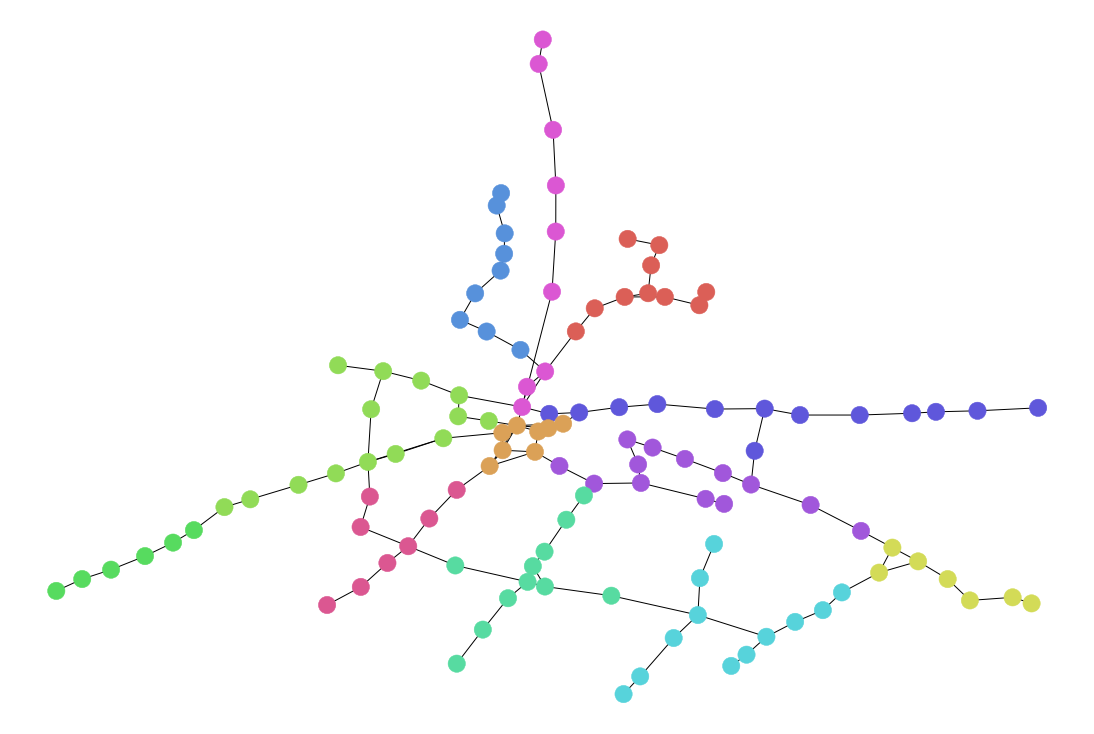

In [27]:
plt.figure(figsize=(15,10))
nx.draw(D, nx.get_node_attributes(D, 'location'), with_labels=False, node_size=300, node_color=node_colors)

Komentarz do grupowania


### Trzy wizualizacje

In [28]:
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin[::-1]
    lat2, lon2 = destination[::-1]
    radius = 6371  # km

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = (sin(dlat / 2) * sin(dlat / 2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) * sin(dlon / 2))
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    d = radius * c

    return d



In [35]:
best_centrality = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue
    T = deepcopy(D)
    T.add_edge(source, target)
    centrality = nx.eigenvector_centrality(T).values()
    mean_centrality = np.mean(list(centrality))

    if mean_centrality < best_centrality:
        best_centrality=mean_centrality
        new_edge = (source,target)
new_edge

7140it [01:17, 92.03it/s] 


('Rondo Kaponiera', 'Poznań Główny')

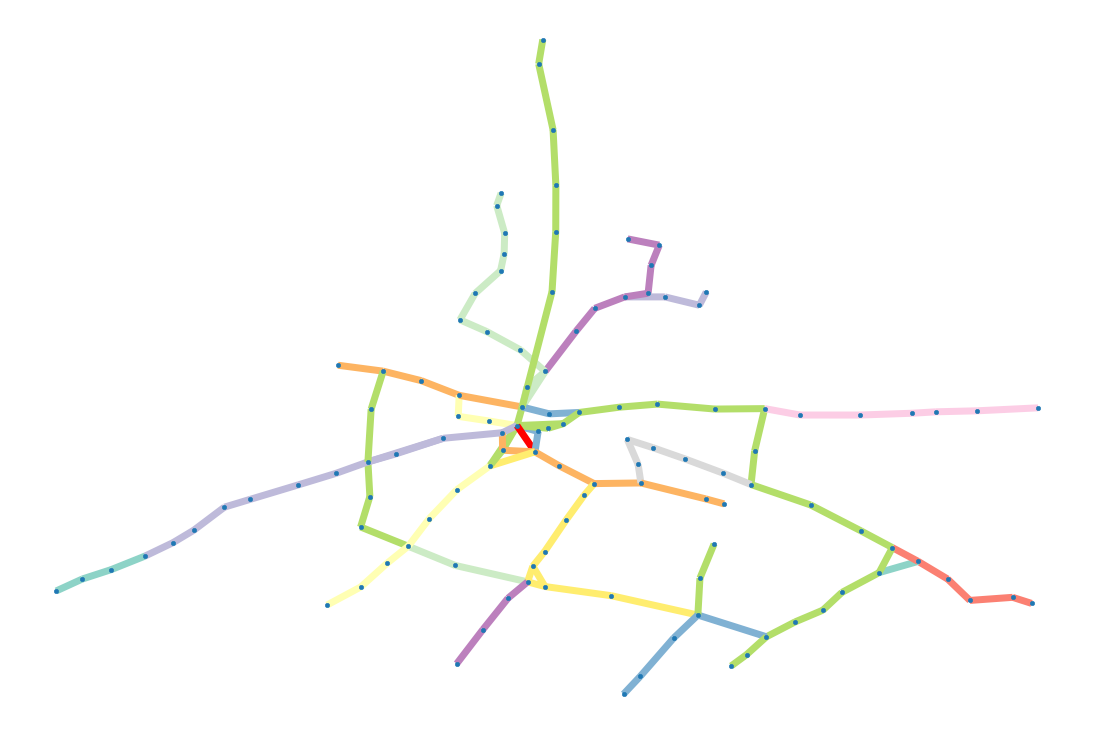

In [36]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)


In [32]:
best_centrality = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue
    T = deepcopy(D)
    T.add_edge(source, target)
    centrality = nx.eigenvector_centrality(T).values()
    mean_centrality = np.mean(nlargest(5, centrality))

    if mean_centrality < best_centrality:
        best_centrality=mean_centrality
        new_edge = (source,target)
new_edge


7140it [01:18, 90.93it/s] 


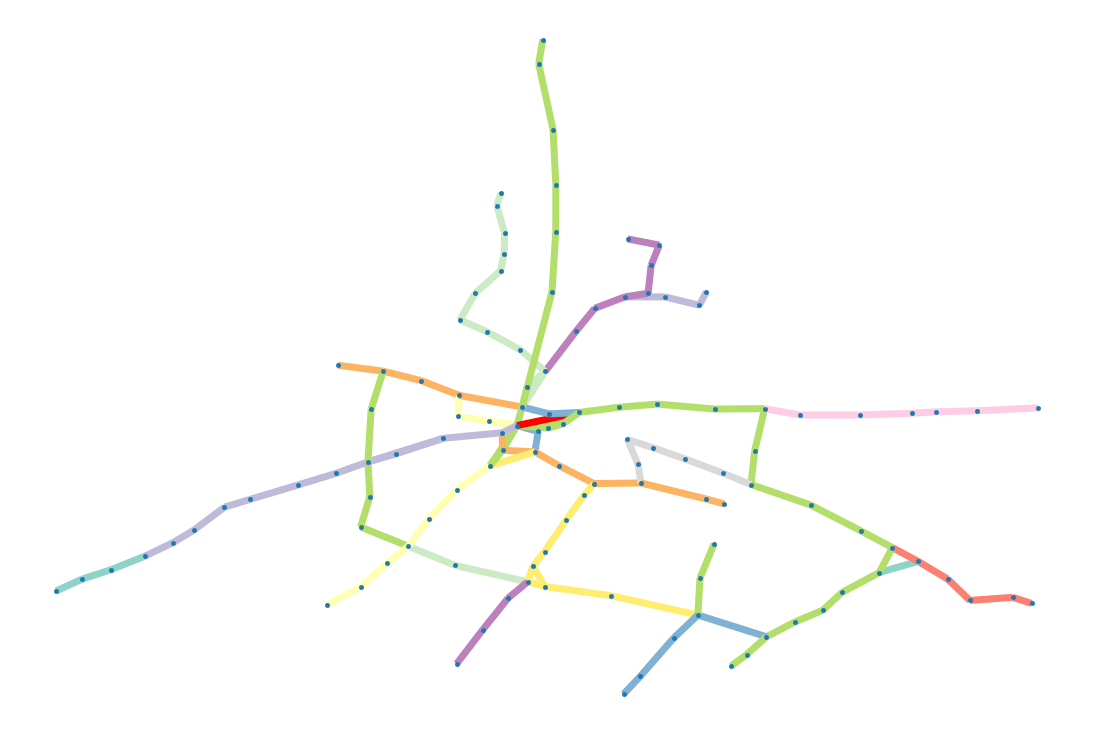

In [33]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)

In [37]:
best_centrality = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue
    T = deepcopy(D)
    T.add_edge(source, target)
    centrality = nx.betweenness_centrality(T).values()
    mean_centrality = np.mean(list(centrality))

    if mean_centrality < best_centrality:
        best_centrality=mean_centrality
        new_edge = (source,target)
new_edge

7140it [04:48, 24.74it/s]


('Rondo Żegrze', 'Most Teatralny')

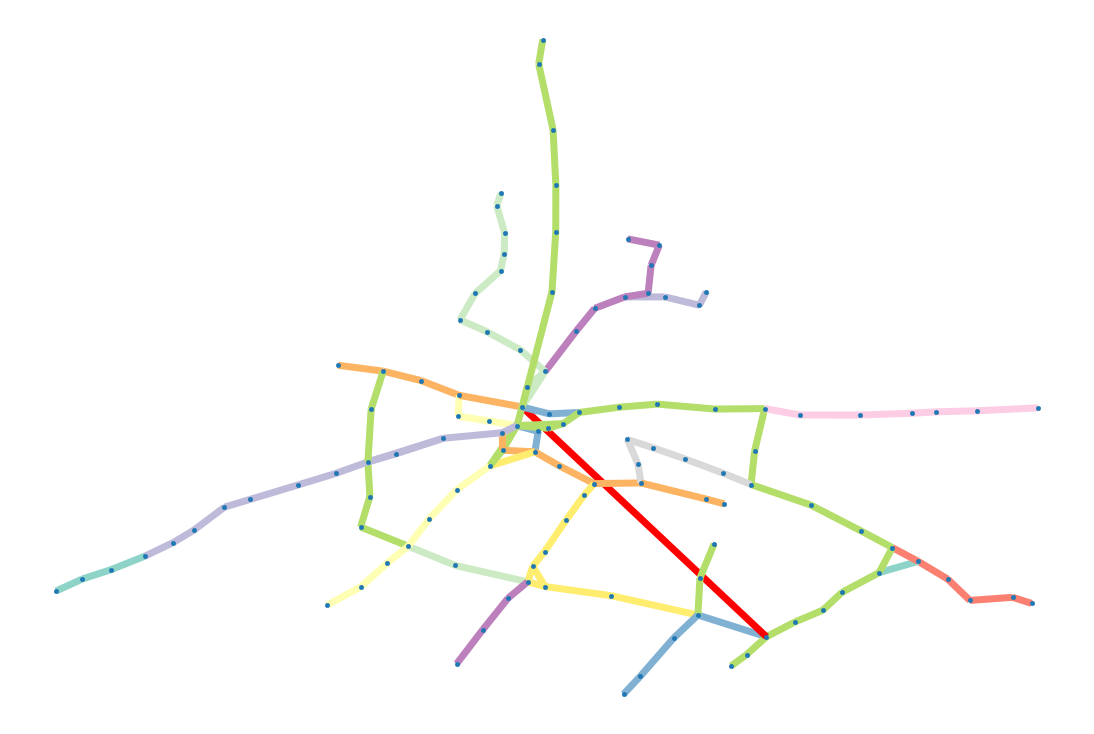

In [38]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)

In [ ]:
max_between_centrality = max(nx.eigenvector_centrality(D).values())
max_distance = float('-inf')
for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])
    if d> max_distance:
        max_distance = d
max_distance, max_between_centrality

In [41]:
best_loss = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue

    T = deepcopy(D)
    T.add_edge(source, target)

    centrality = nx.betweenness_centrality(T).values()
    mean_centrality = np.mean(list(centrality))

    d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])

    loss = mean_centrality/max_between_centrality + d/max_distance

    if loss < best_loss:
        best_loss=loss
        new_edge = (source,target)
new_edge

7140it [04:26, 26.80it/s]


('Towarowa', 'Zamek')

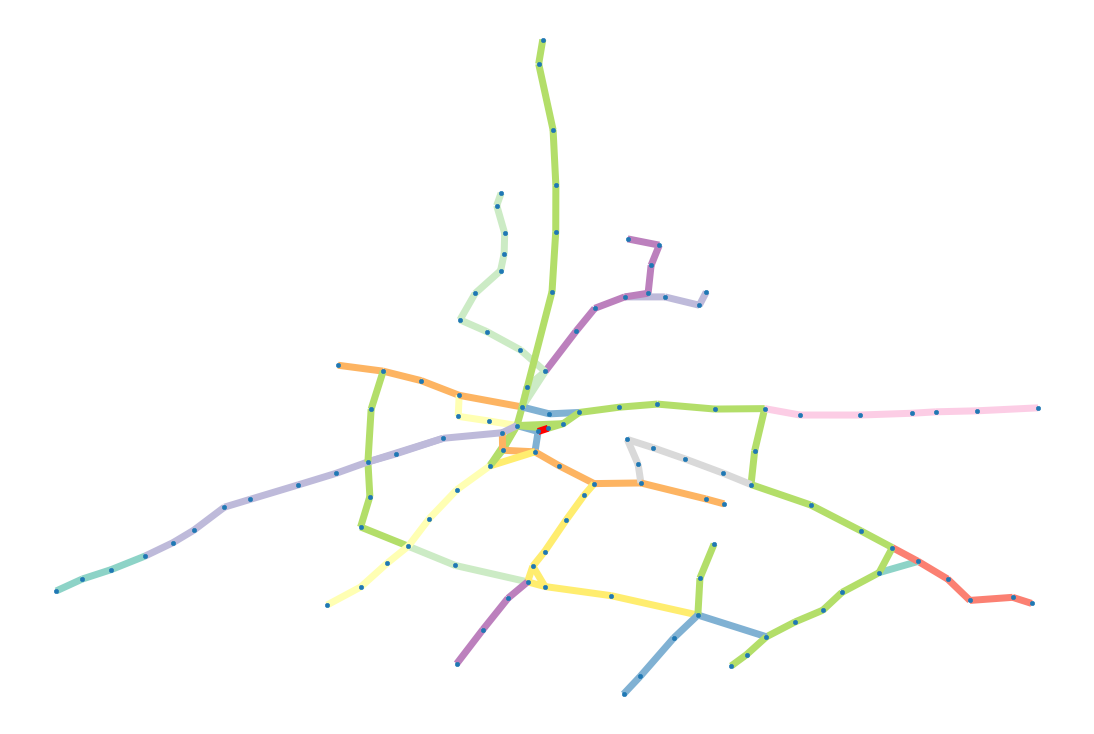

In [42]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)

In [43]:
best_loss = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue

    T = deepcopy(D)
    T.add_edge(source, target)

    centrality = nx.betweenness_centrality(T).values()
    mean_centrality = np.mean(nlargest(5,centrality))

    d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])

    loss = mean_centrality/max_between_centrality + d/max_distance

    if loss < best_loss:
        best_loss=loss
        new_edge = (source,target)
new_edge

7140it [04:27, 26.73it/s]


('Wielkopolska', 'Most Dworcowy')

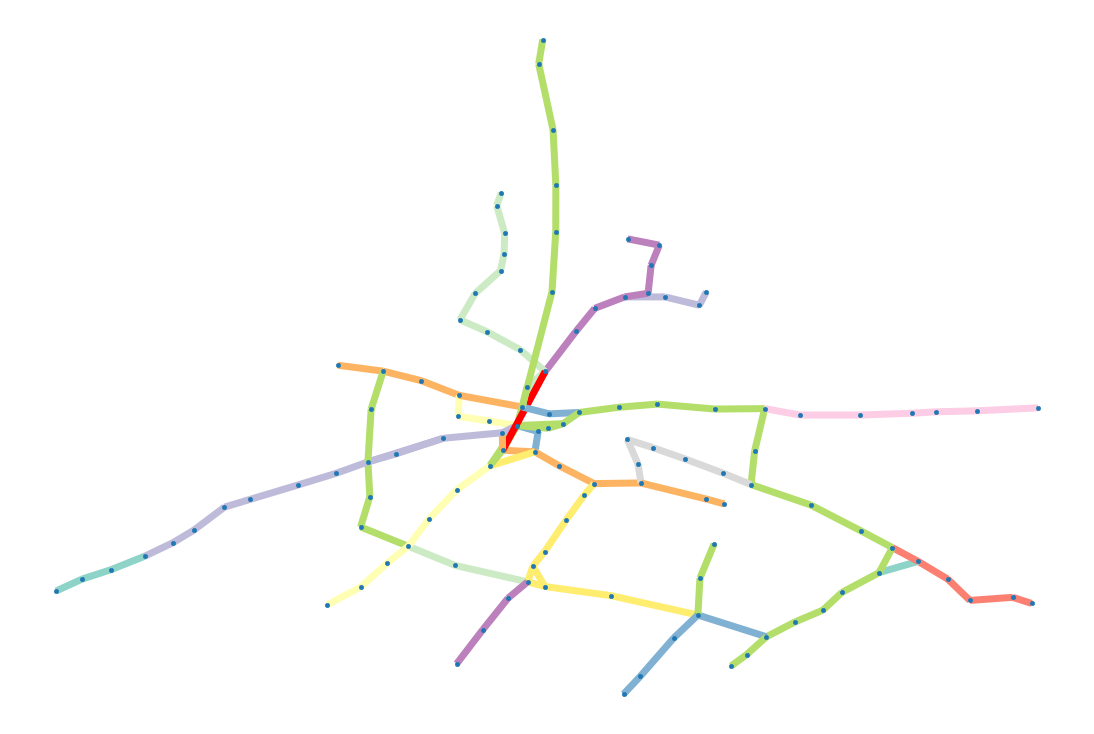

In [44]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)

In [49]:
best_loss = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue

    T = deepcopy(D)
    T.add_edge(source, target)

    centrality = nx.betweenness_centrality(T).values()
    mean_centrality = np.mean(list(centrality))

    d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])

    loss = mean_centrality/max_between_centrality + 0.3 * d/max_distance

    if loss < best_loss:
        best_loss=loss
        new_edge = (source,target)
new_edge

7140it [04:28, 26.62it/s]


('Towarowa', 'Zamek')

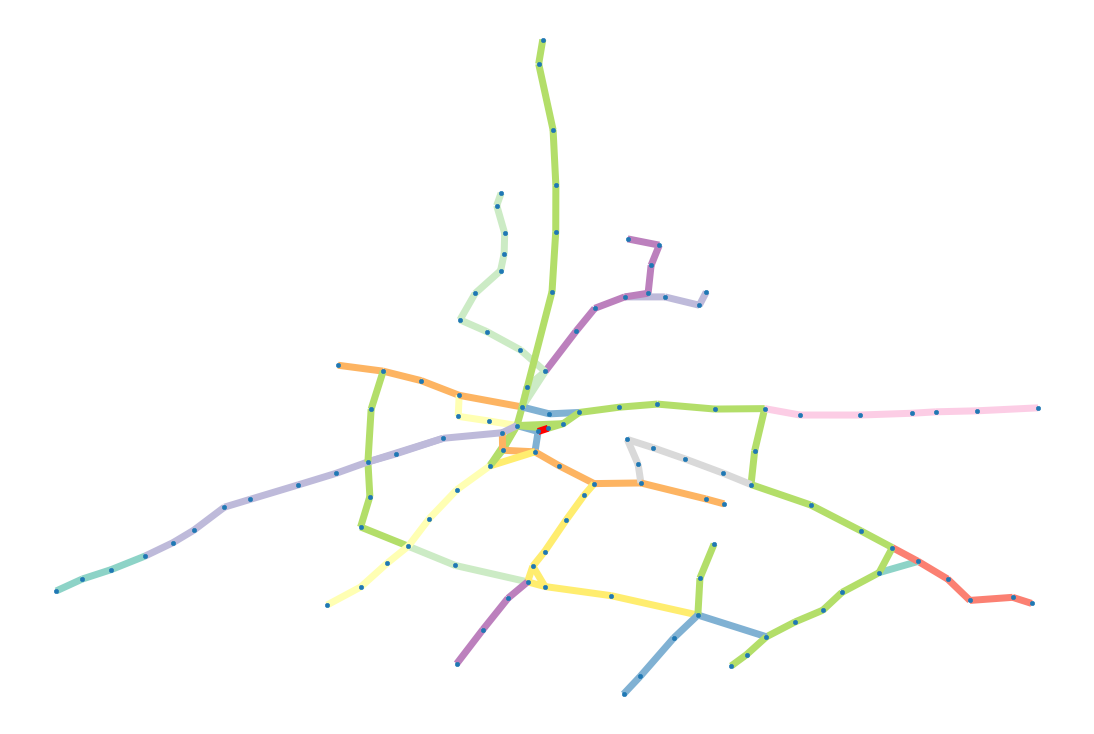

In [50]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)

In [51]:
best_loss = float('inf')
new_edge = None

for source, target in tqdm(combinations(D.nodes().keys(), 2)):
    if (source, target) in D.edges():
        continue

    T = deepcopy(D)
    T.add_edge(source, target)

    centrality = nx.betweenness_centrality(T).values()
    mean_centrality = np.mean(nlargest(5,centrality))

    d = distance(D.nodes()[source]['location'], D.nodes()[target]['location'])

    loss = mean_centrality/max_between_centrality + 0.3 *  d/max_distance

    if loss < best_loss:
        best_loss=loss
        new_edge = (source,target)
new_edge

7140it [04:44, 25.09it/s]


('Poznań Główny', 'Klin')

7140it [04:28, 26.62it/s]


('Poznań Główny', 'Klin')

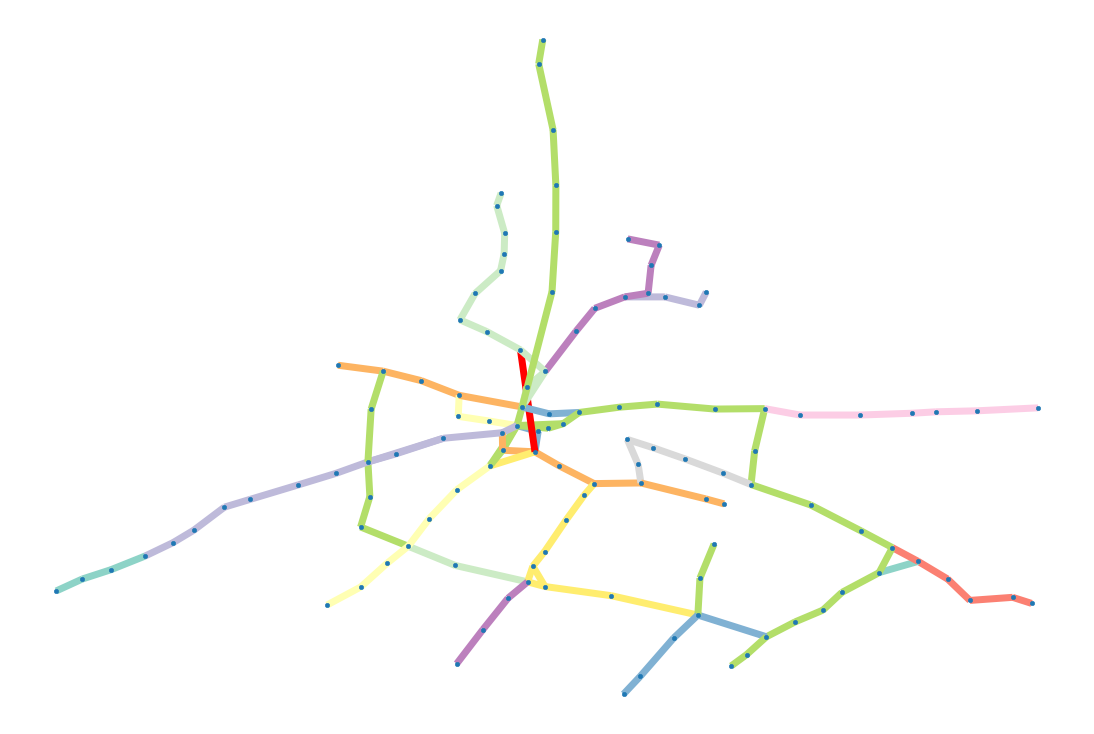

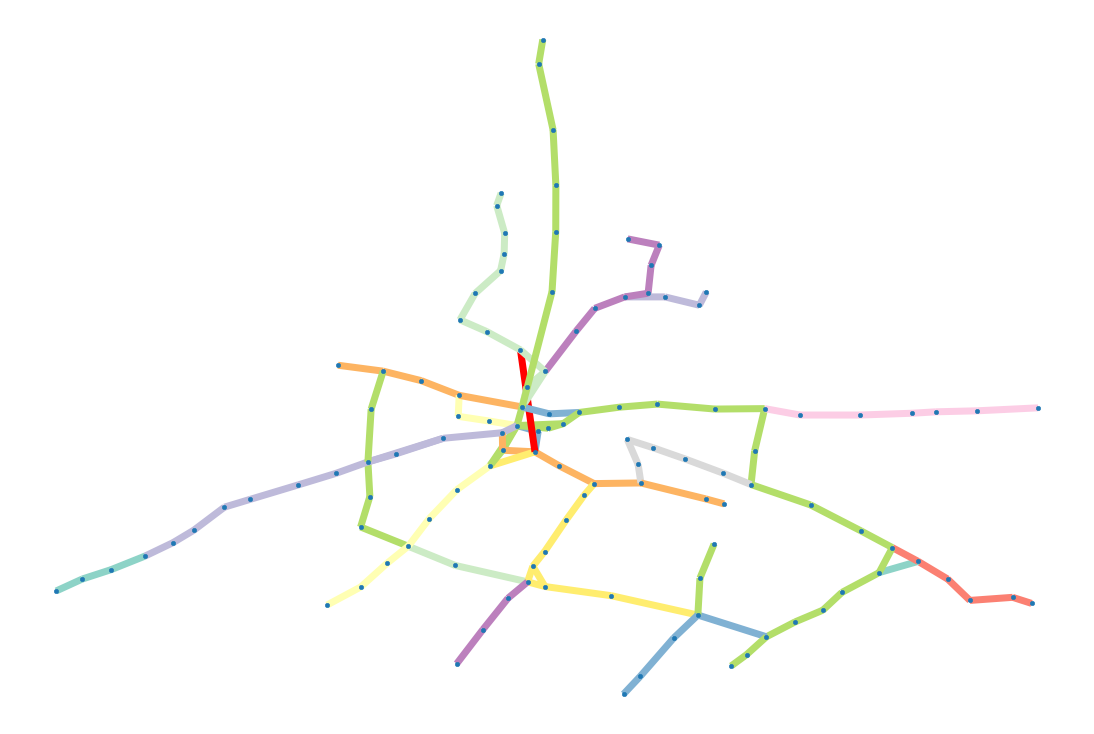

In [52]:
E = deepcopy(D)
E.add_edge(*new_edge, color=[1,0,0])
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(E,'color').values()
nx.draw(E, nx.get_node_attributes(E, 'location'), with_labels=False, node_size=20, edge_color=colors, width=7)


# Podsumowanie
Odpowiedź na pytania biznesowe

